## Lab 2: Classification
#### Danny Murphy, Kerry Nakayama, Brandon Tarr

#### Introduction
We've followed a very natural data evolution from Lab 1 where we first started reducing the dataset to a more manageable and relevant size by focusing on bookings only and a five class (rather than 100 class) classification task. In the mini lab we fine-tuned our imputation and started experimenting with logistic regression and SVM classification given the attributes that Expedia provided as well as a handful we created ourselves. Neither of these methods were particularly accurate (~36%) at classifying the targeted hotel cluster so now we turn to three new algorithms to attempt to raise our classification accuracy: AdaBoostClassifier, ExtraTreesClassifier, and RandomForestClassifier. These will also be used to attempt a regression exercise on booking_window (one of our added features) to see if we can predict when a user's ideal search window might be for more targeted solicitation.
#### Sources:
We make extensive use of the code provided for the Grand Poobah Classification Notebook for the class and code from Sebastian Raschka book "Python Machine Learning".

### Data Preparation
We will be conducting one classification task on the hotel cluster which has been the objective of this Kaggle dataset from the outset. This class variable is already in proper format as an integer representation of the five top hotel clusters [0]. All the other features are also in proper format, primarily as either integer representations of categorical variables [1:16] or as numeric continuous variables in either float or integer format [17:25].

#### New Variables
As a reminder, these variables were all added by our team to either contextualize the dates that Kaggle provided or to add more continuous variables in the hopes of adding more explanatory power to the model:

ci_week (check in week) = week of the year (1-52)
srch_week (week that the user's search was conducted) = week of the year (1-52)
family_size = adults + children
booking_window = check in date - search date (number of days booked prior to check in)
length_of_stay = check out date - check in date

In [3]:
#Import required packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
# Reduced, imputed, file.
# Data can be downloaded here: https://www.dropbox.com/s/2vcqmorh3n3cm21/train_booked_top5_imputed.csv?dl=0
train_booked_df = pd.read_csv('data/train_booked_top5_imputed.csv')
train_booked_df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [5]:
train_booked_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409662 entries, 0 to 409661
Data columns (total 26 columns):
hotel_cluster                409662 non-null int64
site_name                    409662 non-null int64
posa_continent               409662 non-null int64
user_location_country        409662 non-null int64
user_location_region         409662 non-null int64
user_location_city           409662 non-null int64
user_id                      409662 non-null int64
is_mobile                    409662 non-null int64
is_package                   409662 non-null int64
channel                      409662 non-null int64
srch_destination_id          409662 non-null int64
srch_destination_type_id     409662 non-null int64
is_booking                   409662 non-null int64
hotel_continent              409662 non-null int64
hotel_country                409662 non-null int64
hotel_market                 409662 non-null int64
ci_week                      409662 non-null int64
srch_week             

#### Dimensionality Reduction
We've attempted both logistic regression and SVM methods of classification with limited success using all the data that made sense to use without really doing much formal analysis of the utility of each feature. Now we'll spend some time investigating which features we might be able to eliminate to make our models more simple using Sequential Backward Selection (SBS) and random forest techniques.
#### Sequential Backward Selection
Sebastian Raschka's book provides this SBS algorithm code:

In [6]:
from sklearn.base import clone
from itertools import combinations
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

#### Sequential Backward Selection (Continued)
We are using the Logistic Regression model that we determined from the Mini-Lab to be most efficient while acheiving a consistent level of accuracy. While we understand that this model didn't produce good results, the purpose here is to see if we can't maintain the same level of accuracy with fewer features. To improve speed and performance we will be sampling down to around 30,000 records using a stratified shuffle split.

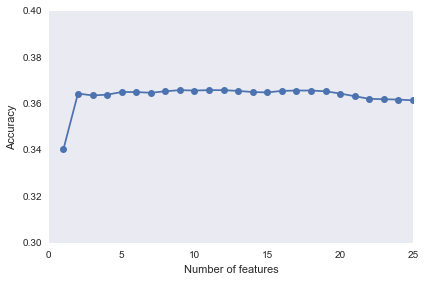

In [200]:
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics as mt
from sklearn.preprocessing import StandardScaler

# we want to predict the X and y data as follows:
# We've put the target as the first attribute to easily assign:
X, y = train_booked_df.iloc[:, 1:].values, train_booked_df.iloc[:, 0].values

# we are sampling way down to improve performance (~30,000 records):
sss = StratifiedShuffleSplit(y, 1, test_size=0.015, train_size=0.06, random_state=0)

stdsc = StandardScaler()

for train_index, test_index in sss:
    X_train_std, X_test_std = stdsc.fit_transform(X[train_index]), stdsc.fit_transform(X[test_index])
    y_train, y_test = y[train_index], y[test_index]
    
lr = LogisticRegression(penalty='l2', C=0.05, class_weight=None, solver='lbfgs')

# selecting features
sbs_lr = SBS(lr, k_features=1)
sbs_lr.fit(X_train_std, y_train)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs_lr.subsets_]

plt.plot(k_feat, sbs_lr.scores_, marker='o')
plt.ylim([0.3, 0.4])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
# plt.savefig('./sbs.png', dpi=300)
plt.show()

In [203]:
# Display individual accuracy scores for each feature subset:
from sets import Set

print("index) , [accuracy] , [feature count] , [feature removed (SBS)] ")

for f in range(X.shape[1]):
    set1 = Set(sbs_lr.subsets_[f])
    if f < X.shape[1] - 1:
        set2 = Set(sbs_lr.subsets_[f + 1])
        k = set1.difference(set2).pop()
    else:
        k = sbs_lr.subsets_[f]
   
    print("%2d) , %-*s , %i , %s" % (f, 10, 
                            sbs_lr.scores_[f], 
                            k_feat[f],
                            train_booked_df.columns[1:][k]))

index) , [accuracy] , [feature count] , [feature removed (SBS)] 
 0) , 0.361432058584 , 25 , booking_window
 1) , 0.361757526444 , 24 , srch_children_cnt
 2) , 0.361920260374 , 23 , srch_adults_cnt
 3) , 0.362082994304 , 22 , hotel_market
 4) , 0.363222131814 , 21 , user_location_region
 5) , 0.364361269325 , 20 , site_name
 6) , 0.365337672905 , 19 , is_mobile
 7) , 0.365663140765 , 18 , is_booking
 8) , 0.365663140765 , 17 , cnt
 9) , 0.365500406835 , 16 , srch_rm_cnt
10) , 0.364849471115 , 15 , srch_destination_id
11) , 0.365012205045 , 14 , is_package
12) , 0.365500406835 , 13 , user_location_city
13) , 0.365825874695 , 12 , srch_destination_type_id
14) , 0.365825874695 , 11 , posa_continent
15) , 0.365663140765 , 10 , srch_week
16) , 0.365825874695 , 9 , user_location_country
17) , 0.365337672905 , 8 , family_size
18) , 0.364686737185 , 7 , channel
19) , 0.365012205045 , 6 , length_of_stay
20) , 0.365012205045 , 5 , ci_week
21) , 0.363873067535 , 4 , user_id
22) , 0.363547599675 ,

#### Important Features (LR):
We can see in the graph and the scores that a consistent level of accuracy (~36.5%) can be acheived with either 2 or 20 features with only slightly perceivable dips in between. The most important feature labels are hotel continenent and country followed by user id and distance between user and hotel. In the context of poor accuracy scores using logistic regression this tells us that this model is making a reasonable guess just by looking at the hotel continent with marginal gains made from the remainder of the features (pretty much any of them). We don't really like this accuracy or the underlying implications of these data. It makes logical sense that is_booking should lend no explanatory power to the model since we've already cleansed out all non-bookings. However, this feature is not the least important, that distinction going to hotel market instead. Looking at these features in this way helps us understand why logistic regression isn't the best model. Since we'll be moving away from logistic regression in the remainder of this lab, let's apply the same logic for feature importance but use random forests instead.

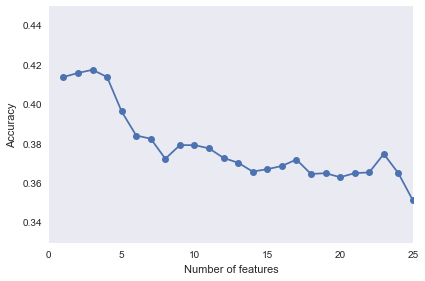

In [201]:
# we are sampling way down to improve performance (~12,000 records):
sss = StratifiedShuffleSplit(y, 1, test_size=0.006, train_size=0.024, random_state=0)

stdsc = StandardScaler()

for train_index, test_index in sss:
    X_train_std, X_test_std = stdsc.fit_transform(X[train_index]), stdsc.fit_transform(X[test_index])
    y_train, y_test = y[train_index], y[test_index]

rf = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=-1)

# selecting features
sbs_rf = SBS(rf, k_features=1)
sbs_rf.fit(X_train_std, y_train)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs_rf.subsets_]

plt.plot(k_feat, sbs_rf.scores_, marker='o')
plt.ylim([0.33, 0.45])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
# plt.savefig('./sbs.png', dpi=300)
plt.show()

In [202]:
# Display individual accuracy scores for each feature subset:
print("index) , [accuracy] , [feature count] , [feature removed (SBS)] ")

for f in range(X.shape[1]):
    set1 = Set(sbs_rf.subsets_[f])
    if f < X.shape[1] - 1:
        set2 = Set(sbs_rf.subsets_[f + 1])
        k = set1.difference(set2).pop()
    else:
        k = sbs_rf.subsets_[f]
   
    print("%2d) , %-*s , %i , %s" % (f, 10, 
                            sbs_rf.scores_[f], 
                            k_feat[f],
                            train_booked_df.columns[1:][k]))

index) , [accuracy] , [feature count] , [feature removed (SBS)] 
 0) , 0.351505288853 , 25 , cnt
 1) , 0.365337672905 , 24 , srch_destination_type_id
 2) , 0.375101708706 , 23 , srch_adults_cnt
 3) , 0.36574450773 , 22 , posa_continent
 4) , 0.365337672905 , 21 , family_size
 5) , 0.363303498779 , 20 , user_location_country
 6) , 0.365337672905 , 19 , length_of_stay
 7) , 0.36493083808 , 18 , hotel_continent
 8) , 0.372253864931 , 17 , channel
 9) , 0.36899918633 , 16 , srch_week
10) , 0.36737184703 , 15 , user_id
11) , 0.366151342555 , 14 , srch_rm_cnt
12) , 0.370626525631 , 13 , is_mobile
13) , 0.373067534581 , 12 , user_location_city
14) , 0.377949552482 , 11 , is_booking
15) , 0.379576891782 , 10 , orig_destination_distance
16) , 0.379576891782 , 9 , site_name
17) , 0.372660699756 , 8 , ci_week
18) , 0.382831570382 , 7 , booking_window
19) , 0.384458909683 , 6 , user_location_region
20) , 0.396663954434 , 5 , srch_children_cnt
21) , 0.414157851912 , 4 , is_package
22) , 0.417819365

#### Important Features (RF):
We can see in the graph and the scores that the best accuracy results come from including between 1-4 features. 

#### Sequential Backward Selection Conclusions:
In the context of logistic regression which we're familiar with from the Mini-Lab, it doesn't seem to influence accuracy much beyond using the hotel continent, country, distance between user and hotel, and length of stay. One could even argue that just continent and country are enough although the test fit does improve with four features. Random Forest SBS also settles on 4 feature as important, although they are not the same 4 features as with logistic regression. What seems to be clear is that some hotel location feature (continent, country, market) are important. Since SBS results bounce around through several iterations we want to explore built-in functions in the Random Forest algorithm before deciding to exclude variables.
#### Random Forest feature selection:
Since we will be using a couple of variations of random forest algorithms in our classification task let's see what this algorithm's feature_importances function determines to have explanatory power:

 1) hotel_market                   0.101945
 2) orig_destination_distance      0.092291
 3) srch_destination_id            0.090225
 4) user_id                        0.088309
 5) user_location_city             0.084437
 6) booking_window                 0.072482
 7) ci_week                        0.070505
 8) srch_week                      0.070179
 9) user_location_region           0.069578
10) length_of_stay                 0.033349
11) channel                        0.030210
12) family_size                    0.026629
13) srch_destination_type_id       0.026287
14) hotel_country                  0.024099
15) hotel_continent                0.022566
16) srch_adults_cnt                0.021075
17) user_location_country          0.016440
18) srch_children_cnt              0.014404
19) site_name                      0.012548
20) is_mobile                      0.010029
21) srch_rm_cnt                    0.009013
22) is_package                     0.005710
23) posa_continent              

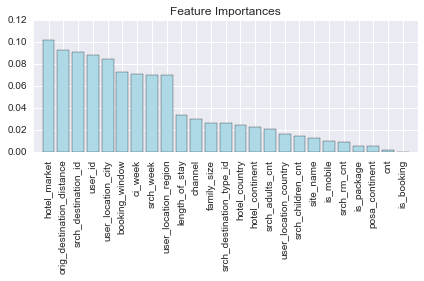

In [190]:
feat_labels = train_booked_df.columns[1:]

forest = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=-1)

forest.fit(X, y)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importances')
plt.bar(range(X.shape[1]), 
        importances[indices],
        color='lightblue', 
        align='center')

plt.xticks(range(X.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
#plt.savefig('./random_forest.png', dpi=300)
plt.show()

#### Random Forest Feature Importances:
This interpretation makes more sense from the outset. First we're directed toward our litmus test variable is_booking which turns out to have no explanatory power as we would expect. Good start. We end up with 9 features that make up 77.3% feature importances in our model. Let's test how these perform compared to the full model:

In [198]:
# Create reduced df based on important features:
reduced_df = train_booked_df[['hotel_cluster','hotel_market','srch_destination_id','orig_destination_distance',
                            'user_id','user_location_city','srch_week','ci_week','booking_window',
                            'user_location_region']]

In [199]:
reduced_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409662 entries, 0 to 409661
Data columns (total 10 columns):
hotel_cluster                409662 non-null int64
hotel_market                 409662 non-null int64
srch_destination_id          409662 non-null int64
orig_destination_distance    409662 non-null float64
user_id                      409662 non-null int64
user_location_city           409662 non-null int64
srch_week                    409662 non-null int64
ci_week                      409662 non-null int64
booking_window               409662 non-null int64
user_location_region         409662 non-null int64
dtypes: float64(1), int64(9)
memory usage: 31.3 MB


#### Full model fit:
As a reminder of accuracy performance let's fit using all the features:

In [192]:
forest.fit(X, y)
print('Training accuracy:', forest.score(X, y))
print('Test accuracy:', forest.score(X, y))

('Training accuracy:', 0.99989828094802158)
('Test accuracy:', 0.99989828094802158)


In [37]:
# Fitting on 2 features:
lr.fit(X_train_std[:, k2], y_train)
print('Training accuracy:', lr.score(X_train_std[:, k2], y_train))
print('Test accuracy:', lr.score(X_test_std[:, k2], y_test))

('Training accuracy:', 0.36848737829121009)
('Test accuracy:', 0.36689734295094772)


In [38]:
# Fitting on 4 features:
lr.fit(X_train_std[:, k4], y_train)
print('Training accuracy:', lr.score(X_train_std[:, k4], y_train))
print('Test accuracy:', lr.score(X_test_std[:, k4], y_test))

('Training accuracy:', 0.36892981701344707)
('Test accuracy:', 0.36805682691955621)


In [44]:
# Fitting on 12 features:
lr.fit(X_train_std[:, k12], y_train)
print('Training accuracy:', lr.score(X_train_std[:, k12], y_train))
print('Test accuracy:', lr.score(X_test_std[:, k12], y_test))

('Training accuracy:', 0.36831650540538069)
('Test accuracy:', 0.36743436710482957)


### Modeling and Evaluation
#### Evaluation Metrics
#### Training/Testing Split Strategy
#### Modeling: Classification Task
Once again we are sampling way down to improve performance by taking approximately 40,000 records. We're using stratified shuffle split to easily sub-sample by our class proportions even though we don't really care about the test data since we'll be using stratified k-fold next. 

In [168]:
cv_object = StratifiedShuffleSplit(y, n_iter=1, test_size=0.001, train_size=0.099)

stdsc = StandardScaler()
  
# Now we
for train_index, test_index in cv_object:
    X_train_std, X_test_std = stdsc.fit_transform(X[train_index]), stdsc.fit_transform(X[test_index])
    y_train, y_test = y[train_index], y[test_index]
    
print cv_object

StratifiedShuffleSplit(labels=[91 59 ..., 59 42], n_iter=1, test_size=0.001, random_state=None)


In [188]:
# create variables we are more familiar with
X, y = X_train_std, y_train
yhat = np.zeros(y.shape) # we will fill this with predictions

# create cross validation iterator
cv = StratifiedKFold(y, n_folds=10)

# get a handle to the classifier object, which defines the type
# clf = RandomForestClassifier(max_depth=50, n_estimators=50, n_jobs=-1, oob_score=True)

#clf = RandomForestClassifier(max_depth=5, n_estimators=50)
# Accuracy 0.371072319202

# clf = RandomForestClassifier(max_depth=10, n_estimators=50)
# Accuracy 0.368578553616

# clf = RandomForestClassifier(max_depth=25, n_estimators=50)
# Accuracy 0.35710723192

# clf = RandomForestClassifier(max_depth=50, n_estimators=50)
# Accuracy 0.346882793017

# clf = RandomForestClassifier(max_depth=3, n_estimators=50)
# Accuracy 0.372817955112

# clf = RandomForestClassifier(max_depth=3, n_estimators=5)
# Accuracy 0.366583541147

clf = RandomForestClassifier(max_depth=3, n_estimators=10)
# Accuracy 0.375546739904

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv:
    clf.fit(X[train],y[train])
    yhat[test] = clf.predict(X[test])
    
total_accuracy = mt.accuracy_score(y, yhat)
print 'Accuracy', total_accuracy


Accuracy 0.375546739904


#### Analysis: Classification Task
#### Statistics and Model Advantages: Classification Task
#### Attribute Assessment: Classification Task
#### Modeling: Regression Task
#### Analysis: Regression Task
#### Statistics and Model Advantages: Regression Task
#### Attribute Assessment: Regression Task


### Deployment

### Exceptional Work